In [1]:
import copy
import pywt
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
import tensorflow as tf
from model import Company, StockLog, IndexLog, PerformanceLog
from model import start_engine
from datetime import date, datetime
from sklearn.preprocessing import MinMaxScaler
from utils import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

%matplotlib inline
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Read Stock Data

In [2]:
stock = 'ABC'
start = datetime.strptime('2009-07-01', '%Y-%m-%d').date()
finish = datetime.strptime('2019-05-30', '%Y-%m-%d').date()

In [3]:
engine = start_engine()
company = Company().query().get(stock)
stock_log = StockLog().query().filter(StockLog.company==company)
df = pd.read_sql(stock_log.statement, engine)
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)

# Calculate Technical Indicators

In [4]:
for period in [15, 50, 200]:
    df['sma%d' % period] = ta.SMA(df['closing'], timeperiod=period)
for period in [15, 50, 200]:
    df['ema%d' % period] = ta.EMA(df['closing'], timeperiod=period)  
df['macd'], df['macd_sig'], df['macd_hist']  = ta.MACD(df['closing'], fastperiod=12, slowperiod=26, signalperiod=9)
df['bb_hi'], df['bb_mid'], df['bb_lo'] = ta.BBANDS(df['closing'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['closing'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['rsi'] = ta.RSI(df['closing'], timeperiod=14)
df['adx'] = ta.ADX(df['high'], df['low'], df['closing'], timeperiod=14)
df['cci'] = ta.CCI(df['high'], df['low'], df['closing'], timeperiod=14)
df['aroon_dn'], df['aroon_up'] = ta.AROON(df['high'], df['low'], timeperiod=25)
df['chaikin'] = ta.AD(df['high'], df['low'], df['closing'], df['volume'])
df['obv'] = ta.OBV(df['closing'], df['volume'])
df['mom'] = ta.MOM(df['closing'], timeperiod=10)

In [5]:
# for sl in company.stock_logs:
#     print(sl.date, df.loc[sl.date,:])

# Read Fundamental Indicies

In [6]:
sectors = {'Consumer Discretionary': 'discretionary',
           'Consumer Staples': 'staples',
           'Energy': 'energy',
           'Financials': 'financials',
           'Health Care': 'healthcare',
           'Industrials': 'industrials',
           'Information Technology': 'infotech',
           'Materials': 'materials',
           'Telecommunication Services': 'telecom',
           'Utilities': 'utilities',
           'Real Estate': 'realestate'}
sectors_cpy = copy.deepcopy(sectors)
sectors_cpy.pop(company.sector)
sectors_cpy = set([sectors_cpy[sector] for sector in sectors_cpy])

index_log = IndexLog().query()
fi = pd.read_sql(index_log.statement, engine)
indicies = set(fi['index'])
indicies -= sectors_cpy

for idx in indicies:
    new = fi.loc[fi['index'] == idx]
    new = new.rename(columns={'value': idx})
    new.sort_values(by='date', inplace=True)
    new.set_index('date', inplace=True)
    new.drop(new.columns[[0]], axis=1, inplace=True)
    df = df.merge(new, how='outer', left_index=True, right_index=True)
df.rename(columns={sectors[company.sector]: 'sector'}, inplace=True)

# Calculate Fundamental Indicators

In [6]:
perf_log = PerformanceLog().query().filter(PerformanceLog.company==company)
fi = pd.read_sql(perf_log.statement, engine)
fi.set_index('date', inplace=True)

In [7]:
# Price to EPS Ratio
eps = fi['eps']
df = df.merge(eps, how='outer', left_index=True, right_index=True)
df['eps'].interpolate(method='pad', inplace=True)
df['pe_ratio'] = df.apply(lambda x: x['closing'] / x['eps'] * 100, axis=1)
df.drop(['eps'], axis=1, inplace=True)

In [8]:
# Dividend to Price Ratio (Dividend Yield)
dividend = fi['net_dividend']
df = df.merge(dividend, how='outer', left_index=True, right_index=True)
df['net_dividend'].interpolate(method='pad', inplace=True)
df['dp_ratio'] = df.apply(lambda x: x['net_dividend'] / x['closing'], axis=1)
df.drop(['net_dividend'], axis=1, inplace=True)

In [9]:
# Price to Book Ratio
bvps = fi['bv_ps']
df = df.merge(bvps, how='outer', left_index=True, right_index=True)
df['bv_ps'].interpolate(method='pad', inplace=True)
df['pb_ratio'] = df.apply(lambda x: x['closing'] / x['bv_ps'], axis=1)
df.drop(['bv_ps'], axis=1, inplace=True)

# Clean Up

In [10]:
df.drop(df[df.opening == 0].index, inplace=True)
df.dropna(subset=['opening'], inplace=True)

In [11]:
df.set_index('code', append=True, inplace=True)

In [12]:
df.to_sql('test_table', engine, if_exists='append')

In [10]:
df['prime'].interpolate(method='pad', inplace=True)
df['world'].interpolate(method='pad', inplace=True)
df['pacific'].interpolate(method='pad', inplace=True)
df['axvi'].interpolate(method='pad', inplace=True)
df['sector'].interpolate(method='pad', inplace=True)
df['aud_usd'].interpolate(method='pad', inplace=True)
df['twi'].interpolate(method='pad', inplace=True)

KeyError: 'prime'

In [11]:
df.tail()

,opening,high,low,closing,adjusted,volume,macd,macd_sig,macd_hist,bb_hi,...,dp_ratio,pb_ratio,prediction,rank,sma15,sma50,sma200,ema15,ema50,ema200
date,,,,,,,,,,,,,,,,,,,,,
2019-07-18,4.18,4.22,4.15,4.17,4.17,809205.0,0.016367,0.023262,-0.006894,4.335906,...,6.714628,2.182446,None,None,4.198000,4.0630,4.66740,4.178928,4.173185,4.696289
2019-07-19,4.18,4.35,4.18,4.35,4.35,2365140.0,0.028591,0.024327,0.004264,4.360569,...,6.436782,2.276653,None,None,4.218667,4.0662,4.65845,4.200312,4.180119,4.692844
2019-07-22,4.36,4.46,4.29,4.46,4.46,2331945.0,0.046617,0.028785,0.017832,4.409853,...,6.278027,2.334223,None,None,4.238667,4.0802,4.65015,4.232773,4.191095,4.690527
2019-07-23,4.44,4.48,4.26,4.29,4.29,2476425.0,0.046648,0.032358,0.014290,4.418859,...,6.526807,2.245250,None,None,4.238667,4.0936,4.64095,4.239926,4.194973,4.686541
2019-07-24,4.30,4.36,4.27,4.33,4.33,1580817.0,0.049331,0.035753,0.013579,4.425958,...,6.466513,2.266185,None,None,4.243333,4.1092,4.63185,4.251185,4.200268,4.682994


In [140]:
df.drop(df[df.index < start].index, inplace=True)
df.drop(df[df.index > finish].index, inplace=True)

# Transforming the Data

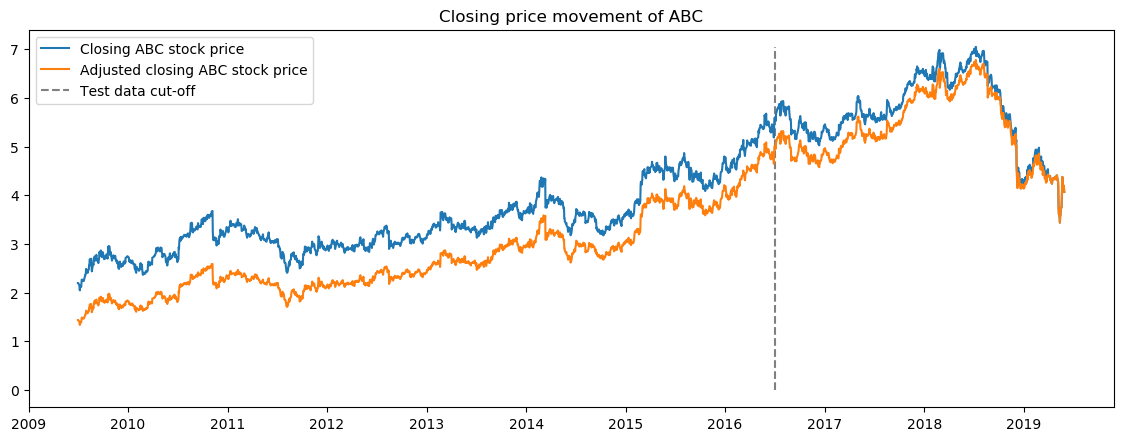

In [141]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df.index, df['closing'], label='Closing %s stock price' % stock)
plt.plot(df.index, df['adjusted'], label='Adjusted closing %s stock price' % stock)
plt.vlines(date(2016, 7, 1), 0, df['closing'].max(), linestyles='--', colors='gray', label='Test data cut-off')
plt.title('Closing price movement of %s' % stock)
plt.legend()
plt.show()

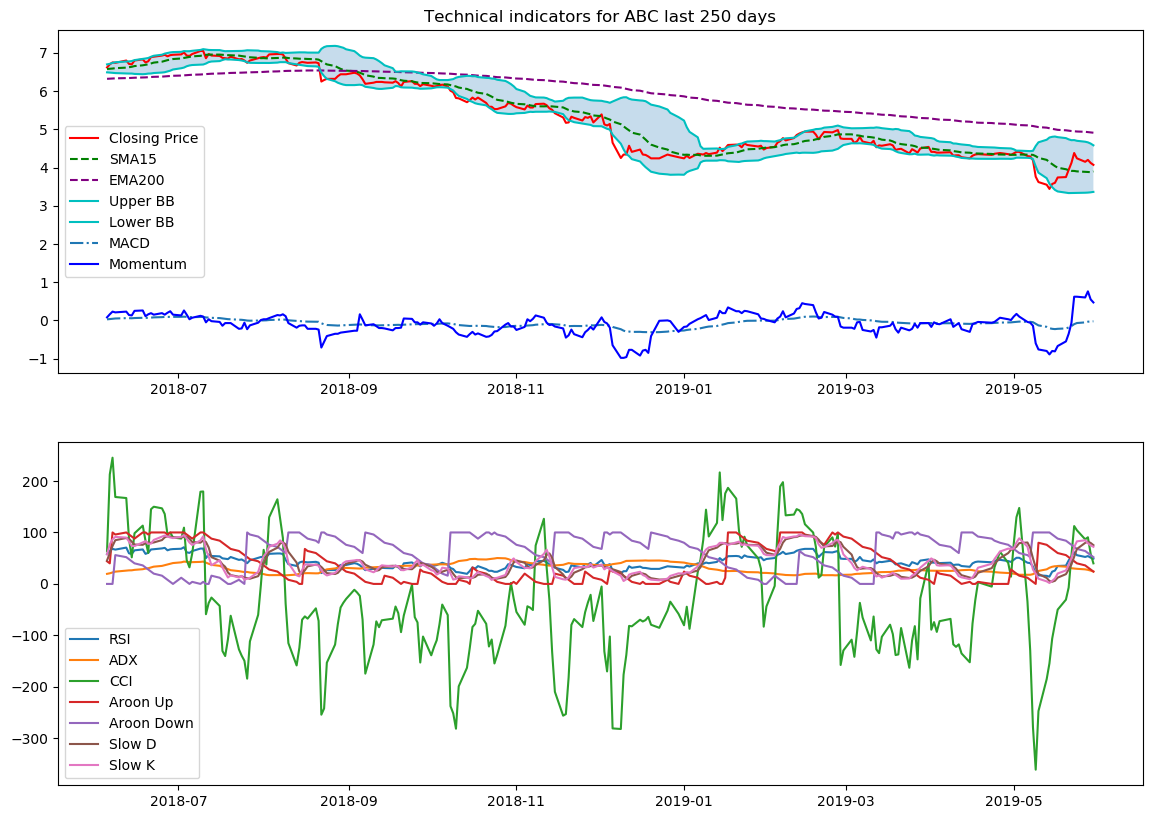

In [145]:
dataset = copy.deepcopy(df)
last_days = 250

plt.figure(figsize=(14, 10), dpi=100)
shape_0 = dataset.shape[0]
xmacd_ = shape_0 - last_days
    
dataset = dataset.iloc[-last_days:, :]
x_ = range(3, dataset.shape[0])
x_ = list(dataset.index)

plt.subplot(2, 1, 1)
plt.plot(dataset['closing'], label='Closing Price', color='r')
plt.plot(dataset['sma15'], label='SMA15', color='g',linestyle='--')
plt.plot(dataset['ema200'], label='EMA200', color='purple',linestyle='--')
plt.plot(dataset['bb_hi'], label='Upper BB', color='c')
plt.plot(dataset['bb_lo'], label='Lower BB', color='c')
plt.plot(dataset['macd'],label='MACD', linestyle='-.')
plt.plot(dataset['mom'], label='Momentum', color='b', linestyle='-')
plt.fill_between(x_, dataset['bb_lo'], dataset['bb_hi'], alpha=0.25)
plt.title('Technical indicators for %s last {} days'.format(last_days) % stock)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(dataset['rsi'], label='RSI', linestyle='-')
plt.plot(dataset['adx'], label='ADX', linestyle='-')
plt.plot(dataset['cci'], label='CCI', linestyle='-')
plt.plot(dataset['aroon_up'], label='Aroon Up', linestyle='-')
plt.plot(dataset['aroon_dn'], label='Aroon Down', linestyle='-')
plt.plot(dataset['slowd'], label='Slow D', linestyle='-')
plt.plot(dataset['slowk'], label='Slow K', linestyle='-')
plt.legend()

plt.show()

In [146]:
data_FT = df[['closing']]
close_fft = np.fft.fft(np.asarray(data_FT['closing'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
x = data_FT['closing']
tx = np.fft.ifft(fft_list)
print('Signal noise: ', x.mean()/x.std())
print('Transform noise: ', tx.mean()/tx.std())

Signal noise:  3.312537737712079
Transform noise:  (3.3131988569158897+2.886238663799072e-17j)


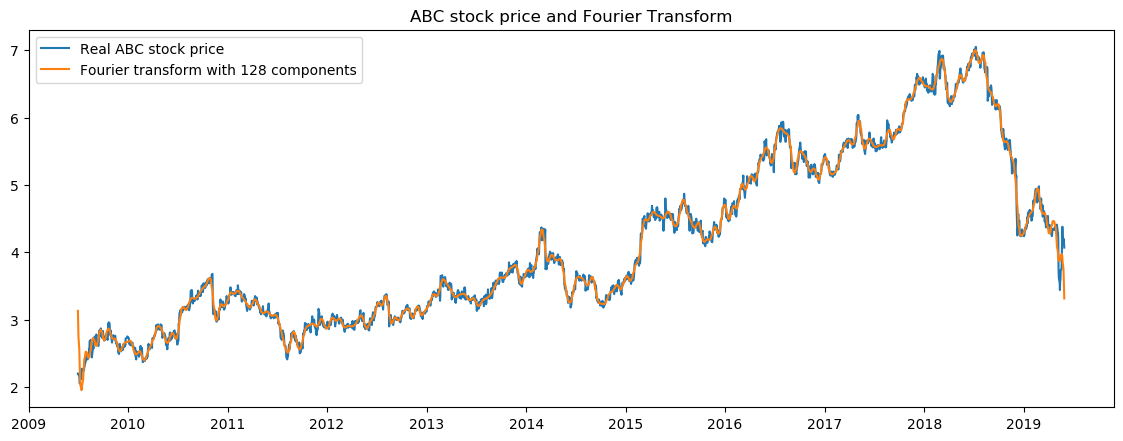

In [147]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data_FT.index, data_FT['closing'], label='Real %s stock price' % stock)
fft_list[128:-128] = 0
plt.plot(data_FT.index, np.fft.ifft(fft_list), label='Fourier transform with 128 components')
plt.title('%s stock price and Fourier Transform' % stock)
plt.legend()
plt.show()

In [148]:
x = np.array(df.iloc[:, 3])
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(x, 'haar', level=4)
cA4 = pywt.threshold(cA4, np.std(cA4), mode="hard")
cD4 = pywt.threshold(cD4, np.std(cD4), mode="hard") 
cD3 = pywt.threshold(cD3, np.std(cD3), mode="hard") 
cD2 = pywt.threshold(cD2, np.std(cD2), mode="hard") 
cD1 = pywt.threshold(cD1, np.std(cD1), mode="hard") 
tx = pywt.waverec((cA4, cD4, cD3, cD2, cD1), 'haar')
df['dwt'] = tx
print('Signal noise: ', x.mean()/x.std())
print('Transform noise: ', tx.mean()/tx.std())

Signal noise:  3.3131988569158906
Transform noise:  3.3154702949918713


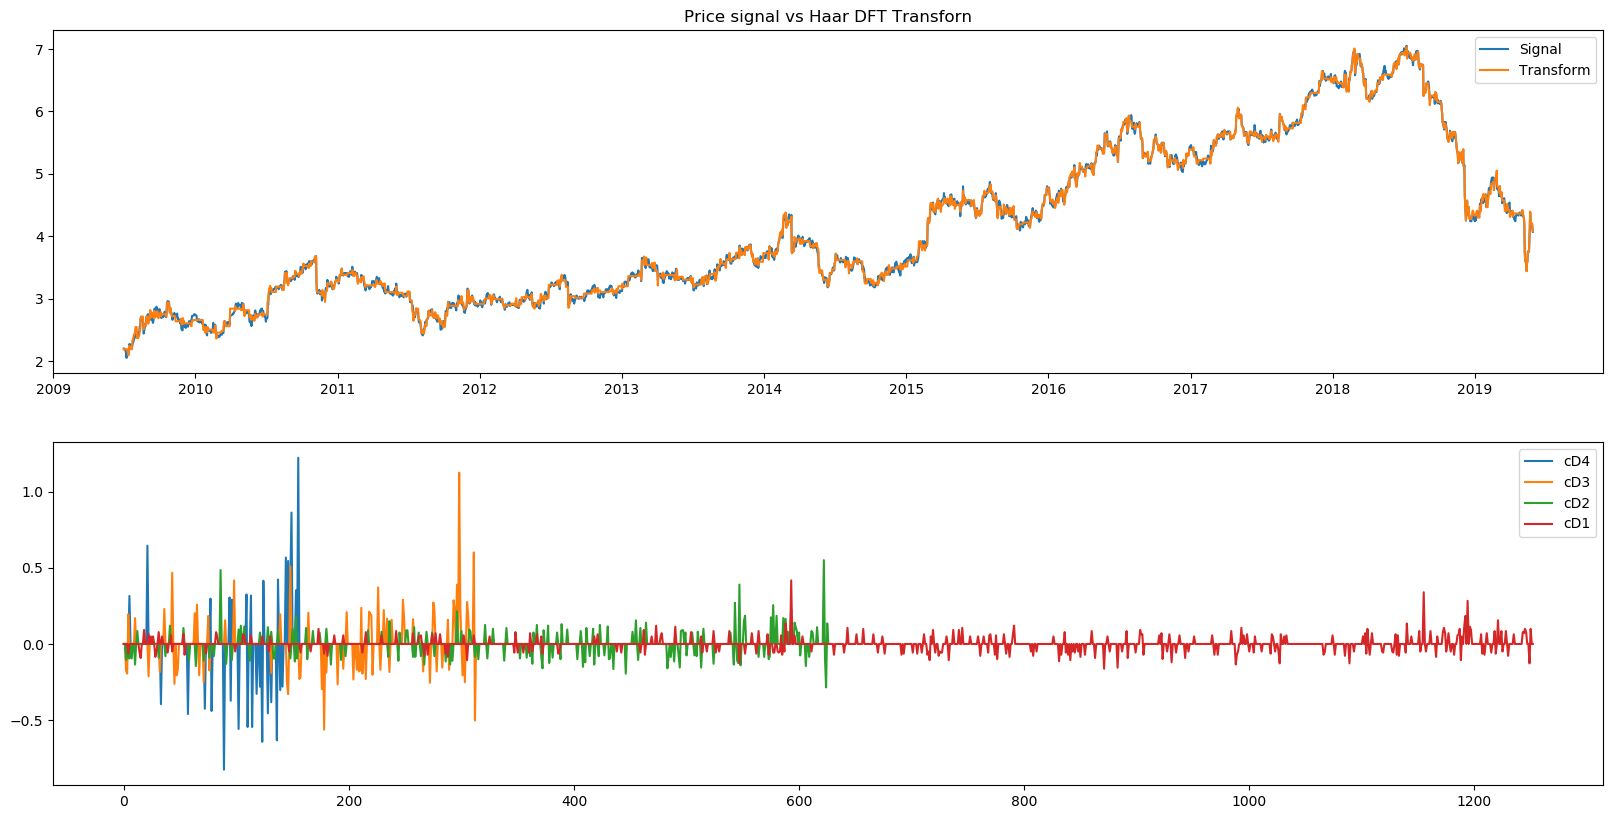

In [149]:
plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(df.index, x, label='Signal')
plt.plot(df.index, tx, label='Transform')
plt.title('Price signal vs Haar DFT Transforn')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(cD4, label='cD4')
plt.plot(cD3, label='cD3')
plt.plot(cD2, label='cD2')
plt.plot(cD1, label='cD1')
plt.legend()
plt.show()

In [150]:
corr = df.iloc[:, 5:-1].corr()

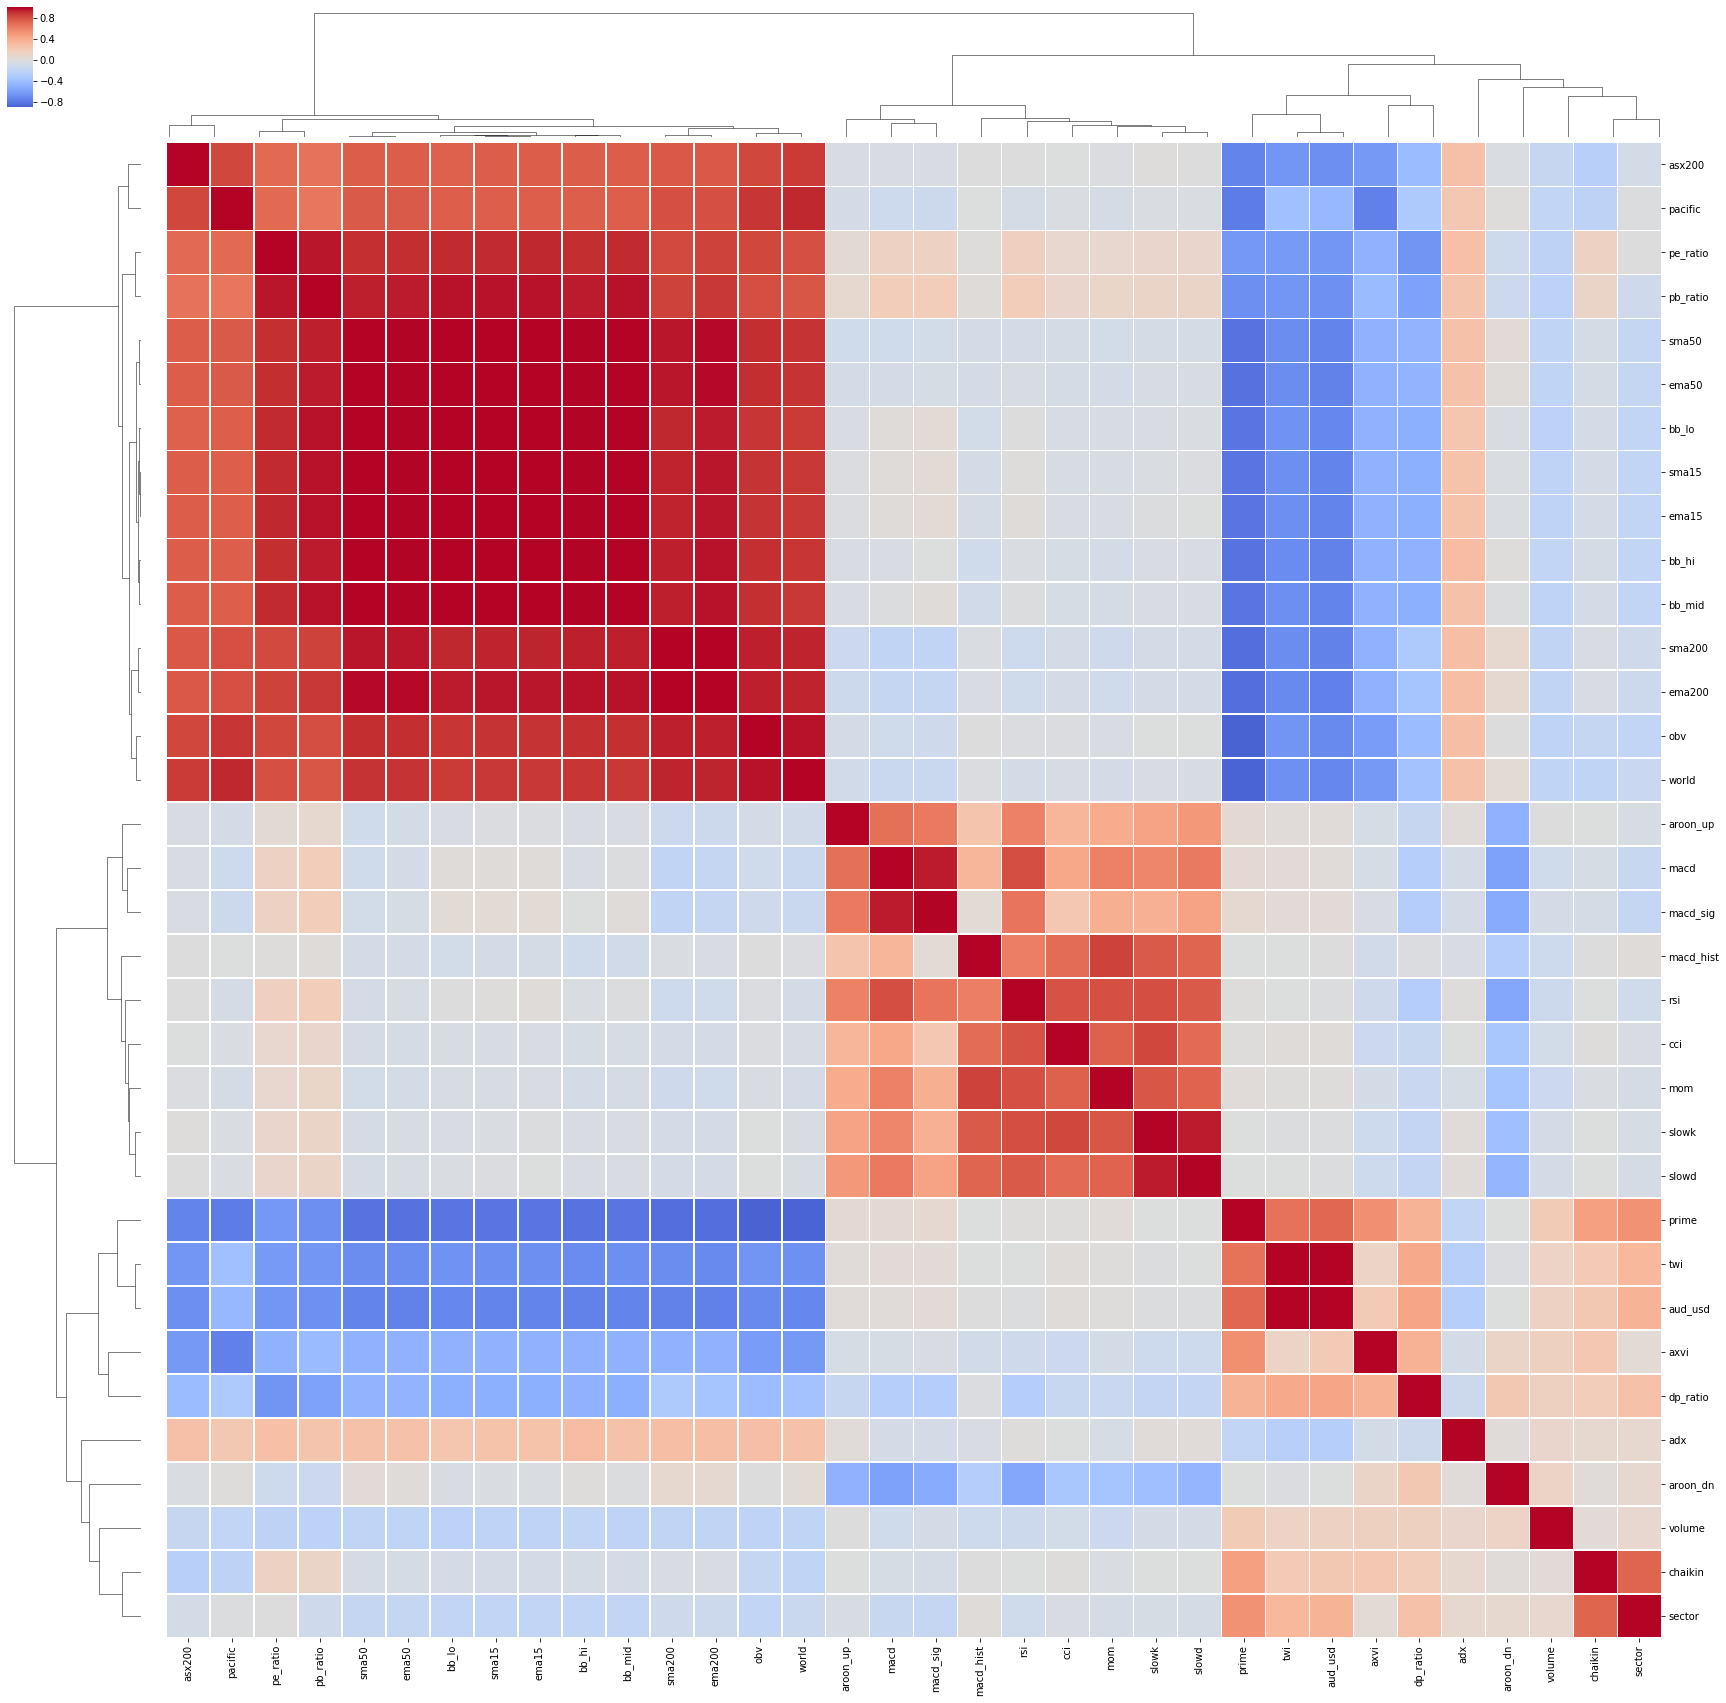

In [151]:
plot = sns.clustermap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, figsize=(30, 30))
plot.savefig("clustermap.png")
plt.show()

# Predictor

In [152]:
df['dwt'] = df['dwt'].shift(-1)
df['closing'] = df['closing'].shift(-1)
df.drop(df.columns[[0, 1, 2, 4]], axis=1, inplace=True)
df.dropna(inplace=True)

In [157]:
# Data split
data = df.values
train_start = 0
train_end = int(np.floor(0.8 * df.shape[0]))
test_start = train_end
test_end = df.shape[0]
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

In [158]:
# Scaling
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [159]:
# Set variables
X_train = data_train[:, 1:-1]
y_train = data_train[:, -1]
X_test = data_test[:, 1:-1]
y_test = data_test[:, -1]

In [160]:
# Model hypers
n_feats = 34
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1
epochs = 25
batch_size = 10

In [161]:
# Placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, n_feats])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [162]:
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [163]:
# Weights
W_hidden_1 = tf.Variable(weight_initializer([n_feats, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [164]:
# Layers
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

In [165]:
# Init
net = tf.InteractiveSession()
mse = tf.reduce_mean(tf.squared_difference(out, Y))
opt = tf.train.AdamOptimizer().minimize(mse)
net.run(tf.global_variables_initializer())
mse_train = []
mse_test = []

In [166]:
for e in range(epochs):
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        if np.mod(i, 50) == 0:
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('Epoch: ', e+1, '\tMSE Train: ', mse_train[-1], '\tMSE Test: ', mse_test[-1])
            pred = net.run(out, feed_dict={X: X_test})

Epoch:  1 	MSE Train:  0.032836422 	MSE Test:  0.03378647
Epoch:  1 	MSE Train:  0.00079575373 	MSE Test:  0.0033417959
Epoch:  1 	MSE Train:  0.00065909623 	MSE Test:  0.0020045592
Epoch:  1 	MSE Train:  0.0007204776 	MSE Test:  0.0030787368
Epoch:  2 	MSE Train:  0.00047305404 	MSE Test:  0.0018043661
Epoch:  2 	MSE Train:  0.0005363113 	MSE Test:  0.0014996688
Epoch:  2 	MSE Train:  0.0005259203 	MSE Test:  0.0016313383
Epoch:  2 	MSE Train:  0.0003874161 	MSE Test:  0.0012208903
Epoch:  3 	MSE Train:  0.0003638953 	MSE Test:  0.0011767121
Epoch:  3 	MSE Train:  0.0006713819 	MSE Test:  0.002374607
Epoch:  3 	MSE Train:  0.00075463485 	MSE Test:  0.0019939938
Epoch:  3 	MSE Train:  0.0010382251 	MSE Test:  0.0022816632
Epoch:  4 	MSE Train:  0.0008173958 	MSE Test:  0.0037149491
Epoch:  4 	MSE Train:  0.00037853123 	MSE Test:  0.0012782435
Epoch:  4 	MSE Train:  0.0013885589 	MSE Test:  0.0052637216
Epoch:  4 	MSE Train:  0.00065724435 	MSE Test:  0.0026400923
Epoch:  5 	MSE Train: 

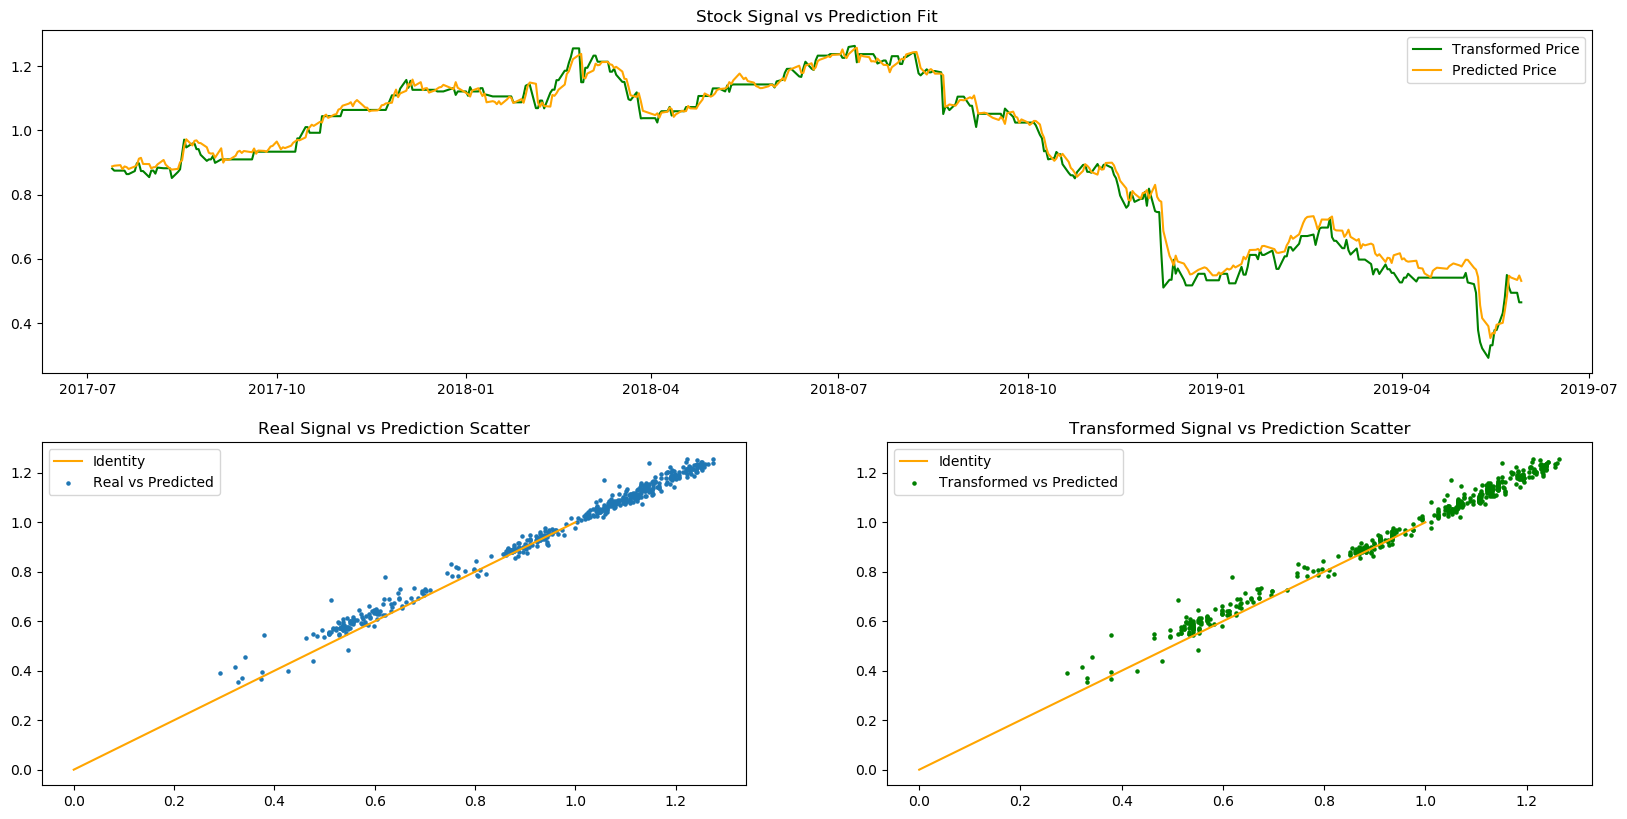

In [168]:
real = 0

plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(2, 1, 1)
if real:
    plt.plot(df[test_start:].index, data_test[:, 0], label='Real Price')
else:
    plt.plot(df[test_start:].index, y_test, label='Transformed Price', c='g')
plt.plot(df[test_start:].index, pred[0], label='Predicted Price', c='orange')
plt.title('Stock Signal vs Prediction Fit')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot([0, 1], [0, 1], c='orange', label='Identity')
plt.scatter(data_test[:, 0], pred[0], label="Real vs Predicted", s=5)
plt.title('Real Signal vs Prediction Scatter')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot([0, 1], [0, 1], c='orange', label='Identity')
plt.scatter(y_test, pred[0], label="Transformed vs Predicted", s=5, c='g')    
plt.title('Transformed Signal vs Prediction Scatter')
plt.legend()

plt.show()